In [ ]:
#default_exp data.datasets.epf

# EPF dataset

> Donwload the EDF dataset.

The EPF dataset was made available as part of the [EPFToolbox](https://github.com/jeslago/epftoolbox/).

The benchmark task is to provide one day ahead hourly forecasts for electricity prices of five markets. The dataset contains:
- Y: Hourly price history for the five markets extending each for six years.
- X: Two covariate factor per market usually electricity load forecasts and renewable sources production.

[Lago, J., Marcjasz, G., De Schutter, B., & Weron, R. (2021). Forecasting day-ahead electricity prices: A review of state-of-the-art algorithms, best practices and an open-access bench-mark. Applied Energy, 293, 116983.](https://www.sciencedirect.com/science/article/pii/S0306261921004529?via%3Dihub)

In [ ]:
#export
import os
from datetime import timedelta
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

from neuralforecast.data.datasets.utils import download_file, Info

>EPF meta information.

In [ ]:
#export
@dataclass
class NP:
    test_date: str = '2016-12-27'
    name: str = 'NP'

@dataclass
class PJM:
    test_date: str = '2016-12-27'
    name: str = 'PJM'

@dataclass
class BE:
    test_date: str = '2015-01-04'
    name: str = 'BE'

@dataclass
class FR:
    test_date: str = '2015-01-04'
    name: str = 'FR'

@dataclass
class DE:
    test_date: str = '2016-01-04'
    name: str = 'DE'

In [ ]:
#export
EPFInfo = Info(groups=('NP', 'PJM', 'BE', 'FR', 'DE'),
               class_groups=(NP, PJM, BE, FR, DE))

In [ ]:
#export
class EPF:
    
    source_url = 'https://sandbox.zenodo.org/api/files/da5b2c6f-8418-4550-a7d0-7f2497b40f1b/'

    @staticmethod
    def load(directory: str,
             group: str) -> Tuple[pd.DataFrame, 
                                  Optional[pd.DataFrame], 
                                  Optional[pd.DataFrame]]:
        """
        Downloads and loads EPF data.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'NP', 'PJM', 'BE', 'FR', 'DE'.
        
        Returns
        -------
        Y: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        X: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        """
        EPF.download(directory)
        class_group = EPFInfo.get_group(group)        
        
        path = f'{directory}/epf/datasets'
        file = f'{path}/{group}.csv'

        df = pd.read_csv(file)

        df.columns = ['ds', 'y'] + \
                     [f'Exogenous{i}' for i in range(1, len(df.columns) - 1)]

        df['unique_id'] = group
        df['ds'] = pd.to_datetime(df['ds'])
        df['week_day'] = df['ds'].dt.dayofweek

        dummies = pd.get_dummies(df['week_day'], prefix='day')
        df = pd.concat([df, dummies], axis=1)

        dummies_cols = [col for col in df if col.startswith('day')]

        Y = df.filter(items=['unique_id', 'ds', 'y'])
        X = df.filter(items=['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day'] + \
                      dummies_cols)
        
        return Y, X, None

    @staticmethod
    def load_groups(directory: str,
                    groups: List[str]) -> Tuple[pd.DataFrame, 
                                                Optional[pd.DataFrame], 
                                                Optional[pd.DataFrame]]:
        """
        Downloads and loads panel of EPF data
        according of groups.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        groups: List[str]
            Group names.
            Allowed groups: 'NP', 'PJM', 'BE', 'FR', 'DE'.

        Returns
        -------
        Y: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        X: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds']. 
            and static variables. 
        """
        Y = []
        X = []
        for group in groups:
            Y_df, X_df, S_df = EPF.load(directory=directory, group=group)
            Y.append(Y_df)
            X.append(X_df)
            
        Y = pd.concat(Y).sort_values(['unique_id', 'ds']).reset_index(drop=True)
        X = pd.concat(X).sort_values(['unique_id', 'ds']).reset_index(drop=True)

        S = Y[['unique_id']].drop_duplicates().reset_index(drop=True)
        dummies = pd.get_dummies(S['unique_id'], prefix='static')
        S = pd.concat([S, dummies], axis=1)
        
        return Y, X, S
    
    @staticmethod
    def download(directory: str) -> None:
        """
        Downloads EPF Dataset.
        
        Parameters
        ----------
        directory: str
            Directory path to download dataset.
        """
        path = f'{directory}/epf/datasets'
        if not os.path.exists(path):
            for group in EPFInfo.groups:
                download_file(path, EPF.source_url + f'{group}.csv')

In [ ]:
# export
# TODO: extend this to group_by unique_id application
def epf_naive_forecast(Y_df: pd.DataFrame) -> pd.DataFrame:
    """Function to build the naive forecast for electricity price forecasting
    
    The function is used to compute the accuracy metrics MASE and RMAE, the function
    assumes that the number of prices per day is 24. And computes naive forecast for
    days of the week and seasonal Naive forecast for weekends.
        
    Parameters
    ----------
    Y_df : pandas.DataFrame
        Dataframe containing the real prices in long format
        that contains variables ['ds', 'unique_id', 'y']
    
    Returns
    -------
    Y_hat_df : pandas.DataFrame
        Dataframe containing the predictions of the epf naive forecast.
    """
    assert type(Y_df) == pd.core.frame.DataFrame
    assert all([(col in Y_df) for col in ['unique_id', 'ds', 'y']])    

    # Init the naive forecast
    Y_hat_df = Y_df[24 * 7:].copy()
    Y_hat_df['dayofweek'] = Y_df['ds'].dt.dayofweek
    
    # Monday, Saturday and Sunday 
    # we have a naive forecast using weekly seasonality
    weekend_indicator = Y_hat_df['dayofweek'].isin([0,5,6])
    
    # Tuesday, Wednesday, Thursday, Friday 
    # we have a naive forecast using daily seasonality
    week_indicator = Y_hat_df['dayofweek'].isin([1,2,3,4])

    naive = Y_df['y'].shift(24).values[24 * 7:]
    seasonal_naive = Y_df['y'].shift(24*7).values[24 * 7:]
    
    Y_hat_df['y_hat'] = naive * week_indicator + seasonal_naive * weekend_indicator
    return Y_hat_df

## Load specific group

In [ ]:
args = pd.Series({'dataset': 'NP'})

Y_df, Xt_df, _ = EPF.load(directory='data', group=args.dataset)

# train_mask: 1 to keep, 0 to mask
offset = 365 * 24 * 2
train_outsample_mask = np.ones(len(Y_df))
train_outsample_mask[-offset:] = 0

print(f'Dataset: {args.dataset}')
#print("Xt_df.columns", Xt_df.columns)
print(f'Train mask percentage: {np.round(np.sum(train_outsample_mask)/len(train_outsample_mask),2)}')
print('X: time series features, of shape (#hours, #times,#features): \t' + str(Xt_df.shape))
print('Y: target series (in X), of shape (#hours, #times): \t \t' + str(Y_df.shape))
print(f'Last ds {Y_df.ds.max()}')
print(f'Train {sum(1-train_outsample_mask)} hours = {np.round(sum(1-train_outsample_mask)/(24*365),2)} years')
print(f'Validation {sum(train_outsample_mask)} hours = {np.round(sum(train_outsample_mask)/(24*365),2)} years')
# print('S: static features, of shape (#series,#features): \t \t' + str(S.shape))
#Y_df.head()
print('\n')

2.12MiB [00:00, 2.52MiB/s]
INFO:nixtlats.data.datasets.utils:Successfully downloaded NP.csv, 2118914, bytes.
2.53MiB [00:01, 2.51MiB/s]
INFO:nixtlats.data.datasets.utils:Successfully downloaded PJM.csv, 2530311, bytes.
1.97MiB [00:00, 2.44MiB/s]
INFO:nixtlats.data.datasets.utils:Successfully downloaded BE.csv, 1974555, bytes.
2.00MiB [00:01, 1.92MiB/s]
INFO:nixtlats.data.datasets.utils:Successfully downloaded FR.csv, 1996871, bytes.
2.10MiB [00:00, 2.54MiB/s]
INFO:nixtlats.data.datasets.utils:Successfully downloaded DE.csv, 2095831, bytes.


Dataset: NP
Train mask percentage: 0.67
X: time series features, of shape (#hours, #times,#features): 	(52416, 12)
Y: target series (in X), of shape (#hours, #times): 	 	(52416, 3)
Last ds 2018-12-24 23:00:00
Train 17520.0 hours = 2.0 years
Validation 34896.0 hours = 3.98 years




## Load all groups

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 22

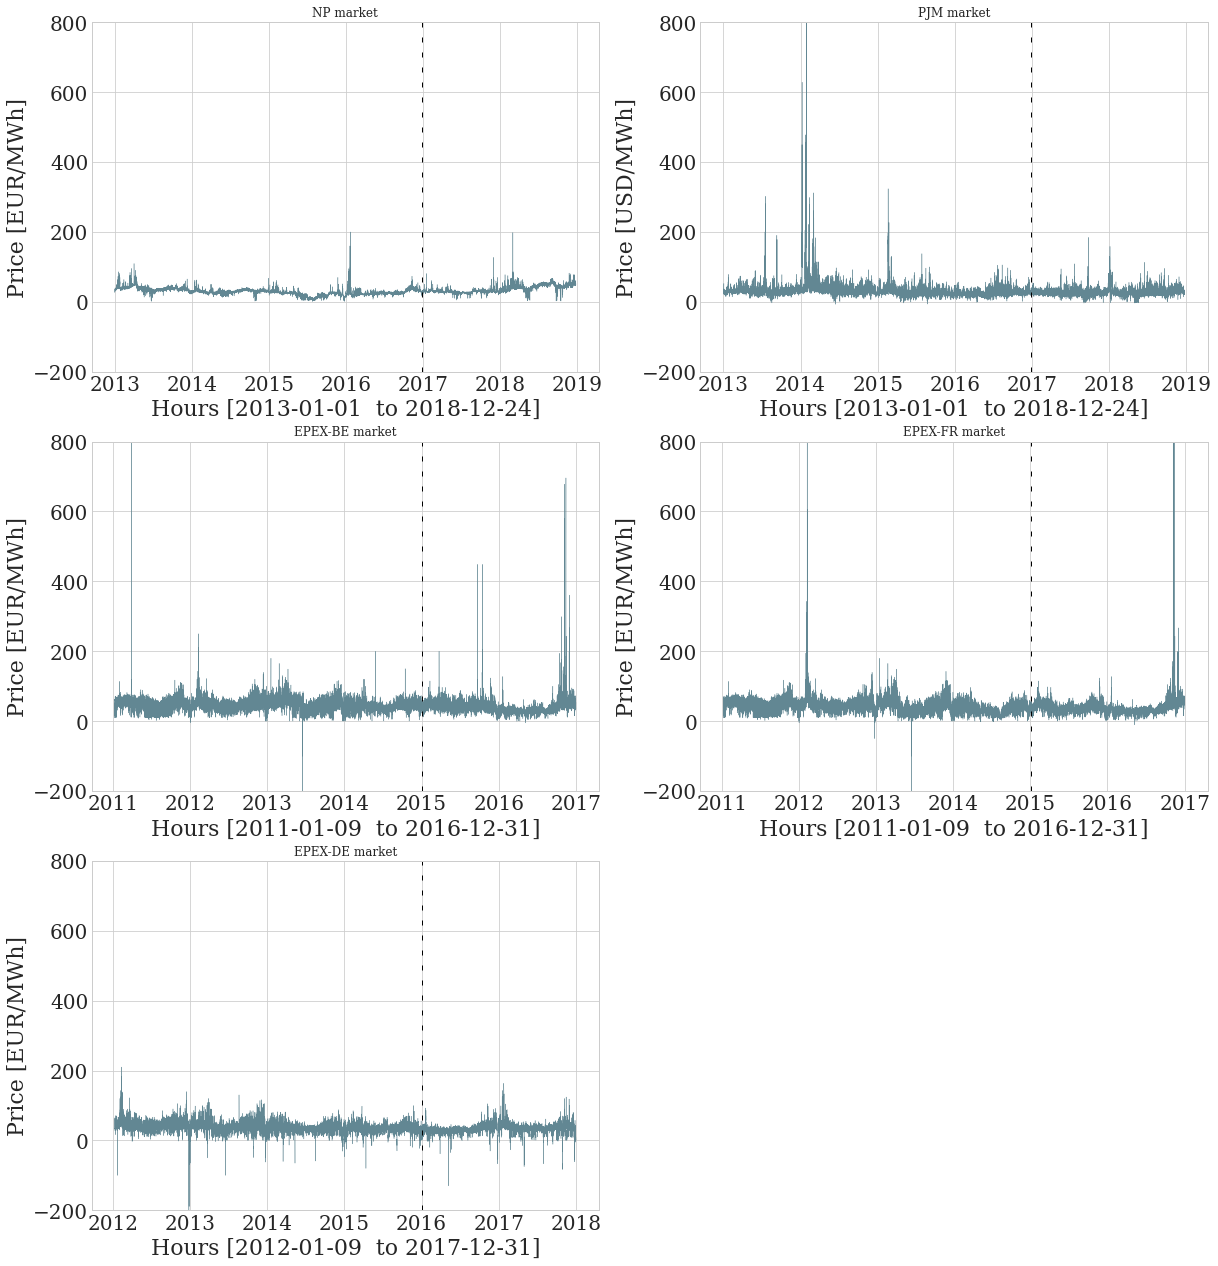

In [ ]:
from neuralforecast.data.datasets.epf import EPF, EPFInfo
if not os.path.exists('./results/'):
    os.makedirs('./results/')

dataset = ['NP', 'PJM', 'BE', 'FR', 'DE']
Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

fig = plt.figure(figsize=(20, 15))
fig.tight_layout()
plt.ylim(-200, 800)
rcParams['figure.figsize'] = 15, 15
ax0 = plt.subplot2grid((3,2),(0, 0))
ax1 = plt.subplot2grid((3,2),(0, 1))
ax2 = plt.subplot2grid((3,2),(1, 0))
ax3 = plt.subplot2grid((3,2),(1, 1))
ax4 = plt.subplot2grid((3,2),(2, 0))
axs = [ax0, ax1, ax2, ax3, ax4]

for idx, market in enumerate(dataset):
    currency   = 'USD' if market == 'PJM' else 'EUR'
    title_str  = 'EPEX-' if not (market in ['PJM', 'NP']) else ''
    title_str += f'{market} market'
    y_axis_str = f'Price [{currency}/MWh]'

    x_plot = Y_df[Y_df.unique_id==market].ds.values
    y_plot = Y_df[Y_df.unique_id==market].y.values
    
    x_axis_str = f'Hours [{str(x_plot.min())[:10]}  to {str(x_plot.max())[:10]}]'


    axs[idx].plot(x_plot, y_plot, color='#628793', linewidth=0.4)
    axs[idx].tick_params(labelsize=FONTSIZE-2)
    axs[idx].set_xlabel(x_axis_str, fontsize=FONTSIZE)
    axs[idx].vlines(x_plot[-728*24],-200,800, linestyle=(0, (5, 10)), 
                    color='black', linewidth=1.)
    axs[idx].set_ylabel(y_axis_str, fontsize=FONTSIZE)
    axs[idx].set_title(title_str)
    axs[idx].set_ylim(-200,800)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('./results/market_plots.pdf', bbox_inches = 'tight')
plt.show()

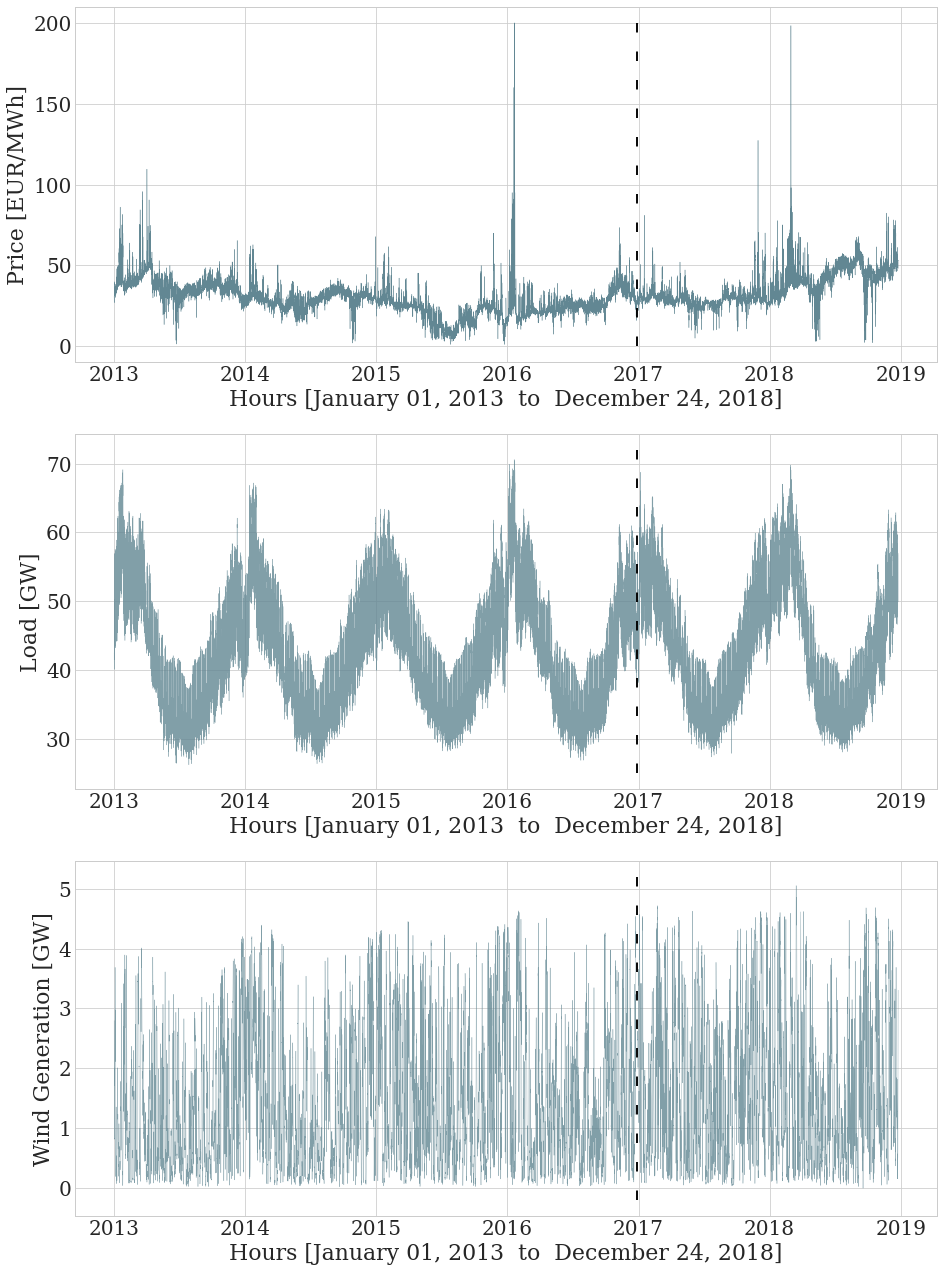

In [ ]:
from neuralforecast.data.datasets.epf import EPF, EPFInfo

EXOGENOUS_NAMES = {'NP': ['Load [GW]', 'Wind Generation [GW]'],
                   'PJM': ['Load [GW]', 'COMED Load [GW]'],
                   'BE': ['Load [GW]', 'Total France Generation [GW]'],
                   'FR': ['Load [GW]', 'Total France Generation [GW]'],
                   'DE': ['TSO Zonal Load [GW]', 'DE Wind Generation [GW]']}

# dataset = ['NP', 'PJM', 'BE', 'FR', 'DE']
dataset = ['NP']
# dataset = ['DE']
Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

fig = plt.figure(figsize=(34, 12))
fig.tight_layout()
plt.ylim(-200, 800)
# rcParams['figure.figsize'] = 15, 15
ax0 = plt.subplot2grid((3,2),(0, 0))
ax1 = plt.subplot2grid((3,2),(1, 0))
ax2 = plt.subplot2grid((3,2),(2, 0))
axs = [ax0, ax1, ax2]

# for idx, market in enumerate(dataset):
market = dataset[0]
currency   = 'USD' if market == 'PJM' else 'EUR'
title_str  = 'EPEX-' if not (market in ['PJM', 'NP']) else ''
title_str += f'{market} market'
y_axis_str = f'Price [{currency}/MWh]'

x_plot = Y_df.ds.values
x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y')
x_plot_max = pd.to_datetime(x_plot.max()).strftime('%B %d, %Y')
x_axis_str = f'Hours [{x_plot_min}  to  {x_plot_max}]'

y_plot = Y_df.y.values
x1_plot = X_df.Exogenous1.values
x2_plot = X_df.Exogenous2.values

axs[0].plot(x_plot, y_plot, color='#628793', linewidth=0.4, alpha=1.)
axs[0].vlines(x_plot[-728*24],0,200, linestyle=(0, (5, 10)), 
              color='black', linewidth=1.9)
axs[0].tick_params(labelsize=FONTSIZE-2)
axs[0].set_xlabel(x_axis_str, fontsize=FONTSIZE)
axs[0].set_ylabel(y_axis_str, fontsize=FONTSIZE)
#axs[0].vlines(x_plot[-728*24],-250,280, linestyle=(0, (5, 10)), 
#              color='black', linewidth=1.)
#axs[0].vlines(x_plot[-728*24],0,210, linestyle=(0, (5, 10)), 
#                color='black', linewidth=1.)

axs[1].plot(x_plot, x1_plot/1000, color='#628793', linewidth=0.37, alpha=0.8)
axs[1].vlines(x_plot[-728*24],25,72, linestyle=(0, (5, 10)), 
              color='black', linewidth=1.9)
axs[1].tick_params(labelsize=FONTSIZE-2)
axs[1].set_xlabel(x_axis_str, fontsize=FONTSIZE)
axs[1].set_ylabel(EXOGENOUS_NAMES[market][0], fontsize=FONTSIZE)

x2_plot[-728*24-60:-728*24+60] = [np.nan] * 60 * 2 # mini hack
axs[2].plot(x_plot, x2_plot/1000, color='#628793', linewidth=0.37, alpha=0.8)
axs[2].vlines(x_plot[-728*24],-.2,5.2, linestyle=(0, (5, 10)), 
              color='black', linewidth=1.9)
axs[2].tick_params(labelsize=FONTSIZE-2)
axs[2].set_xlabel(x_axis_str, fontsize=FONTSIZE)
axs[2].set_ylabel(EXOGENOUS_NAMES[market][1], fontsize=FONTSIZE)

# # axs[idx].set_title(title_str)
# axs[idx].set_ylim(-200,800)
# # print(\x_plot[-728*24]\, x_plot[-728*24])

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.2)
plt.savefig('./results/NP.pdf', bbox_inches = 'tight')
plt.show()

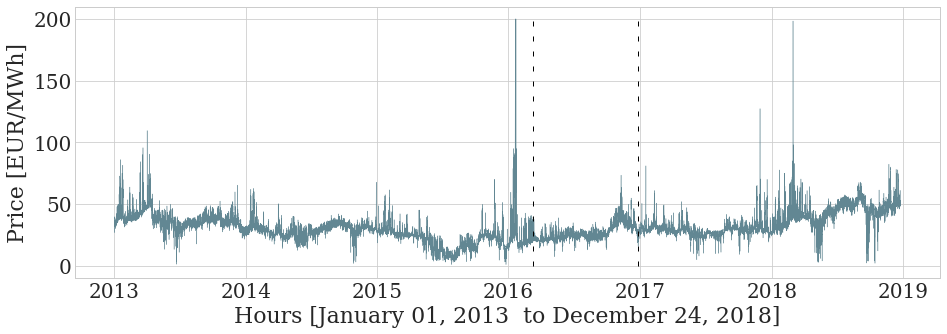

In [ ]:
import pandas as pd 

# dataset = ['NP', 'PJM', 'BE', 'FR', 'DE']
dataset = ['NP']
# dataset = ['DE']
Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

fig = plt.figure(figsize=(15.5, 5))

fig.tight_layout()
plt.ylim(-200, 800)
ax0 = plt.subplot2grid((1,1),(0, 0))
axs = [ax0]

# for idx, market in enumerate(dataset):
market = dataset[0]
currency = 'USD' if market == 'PJM' else 'EUR'
title_str  = 'EPEX-' if not (market in ['PJM', 'NP']) else ''
title_str += f'{market} market'
y_axis_str = f'Price [{currency}/MWh]'

x_plot = Y_df.ds.values
x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y') #'%B %d, %Y, %r'
x_plot_max = pd.to_datetime(x_plot.max()).strftime('%B %d, %Y') #'%B %d, %Y, %r'

x_axis_str = f'Hours [{x_plot_min}  to {x_plot_max}]'

y_plot = Y_df.y.values
x1_plot = X_df.Exogenous1.values
x2_plot = X_df.Exogenous2.values

axs[0].plot(x_plot, y_plot, color='#628793', linewidth=0.4)
axs[0].tick_params(labelsize=FONTSIZE-2)
axs[0].set_xlabel(x_axis_str, fontsize=FONTSIZE)
axs[0].set_ylabel(y_axis_str, fontsize=FONTSIZE)

axs[0].vlines(x_plot[-(42*7*24)-(728*24)],0,200, linestyle=(0, (5, 10)), 
              color='black', linewidth=1.)
axs[0].vlines(x_plot[-728*24],0,200, linestyle=(0, (5, 10)), 
              color='black', linewidth=1.)
plt.savefig('./results/train_methodology.pdf', bbox_inches = 'tight')
plt.show()

# VALIDATION OF EPF SEASONAL NAIVE FORECASTS

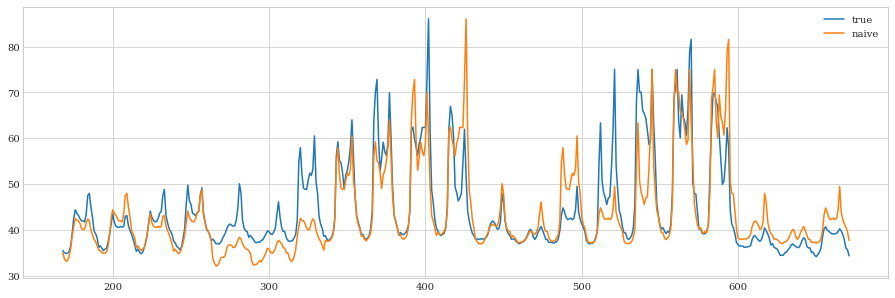

In [ ]:
Y_hat_df = epf_naive_forecast(Y_df)

fig = plt.figure(figsize=(15.5, 5))
plt.plot(Y_hat_df['y'][:24*7*3], label='true')
plt.plot(Y_hat_df['y_hat'][:24*7*3], label='naive')
plt.legend()
plt.show()